### Imports and Environment Setup

In this cell, we set up the environment and import all the libraries required for the project:

- **os**: Used to configure environment variables, suppress TensorFlow warnings, and force CPU usage since the MacBook Air M1 has no GPU.  
- **json**: For reading or writing JSON files if needed in the project.  
- **numpy**: For numerical operations like array manipulation and calculations.  
- **matplotlib.pyplot**: To visualize images, plots, and results.  
- **itertools**: Utility functions for iterators, used later for plotting confusion matrices.  
- **time**: To track execution or training time.  

- **tensorflow & keras**: Core deep learning libraries for building, training, and evaluating CNNs.  
  - **layers**: Provides building blocks like Conv2D, MaxPooling2D, Dense, etc.  
  - **Sequential & Model**: Two ways to define models; Sequential for simple stacks, Model for functional API.  

- **sklearn.metrics**: For evaluating the model’s performance using confusion matrices and classification reports.  

Finally, the cell prints the **Python version, TensorFlow version, and number of GPUs available** to confirm the environment setup and ensure the project will run on CPU.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import confusion_matrix, classification_report

print("Python:", os.sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("Num GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))

Python: 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
TensorFlow: 2.16.2
Num GPUs available: 0


### Configuring TensorFlow for CPU Execution

This cell sets the number of CPU threads TensorFlow can use to ensure efficient execution on a system without GPU support.  

The function `set_cpu_threads` accepts a parameter `num_threads` (default is 4) and configures TensorFlow’s threading behavior:  

- **Inter-op parallelism threads**: Limits the number of threads used to run different independent operations concurrently.  
- **Intra-op parallelism threads**: Limits the number of threads used within a single operation, such as splitting a matrix multiplication task across multiple threads.  

Both are set to the same value to balance performance and prevent TensorFlow from consuming excessive CPU resources.  

A `try-except` block is used for error handling, ensuring that the program prints an informative message instead of crashing if the configuration fails.  

Finally, `set_cpu_threads(4)` applies the configuration and confirms it by printing the number of threads in use.  

In [2]:
def set_cpu_threads(num_threads=4):
    try:
        tf.config.threading.set_inter_op_parallelism_threads(num_threads)
        tf.config.threading.set_intra_op_parallelism_threads(num_threads)
        print(f"Set TF inter/intra op parallelism threads to {num_threads}")
    except Exception as e:
        print("Unable to set threads:", e)

set_cpu_threads(4)

Set TF inter/intra op parallelism threads to 4


### Visualizing Images in a Grid

This cell defines a function to display sample images, their ground truth labels, and optional predictions in a neatly organized grid.  

The function `plot_images_grid` takes a batch of images along with optional labels, predicted values, and class names. It organizes the images into a grid layout specified by the `rows` and `cols` parameters, making it easy to inspect dataset samples or model results visually.  

- **Figure and axes creation**: Sets up a subplot grid with the requested number of rows and columns, adjusting the figure size as needed.  
- **Image display**: Iterates through images, shows each one with proper colormap handling (uses grayscale for single-channel images). If there are fewer images than grid cells, unused cells are hidden.  
- **Titles**: For each image, the title displays the ground truth label (GT) and predicted label (Pred) if provided, optionally converting these from indices to class names for better readability.  
- **Presentation**: Removes axis ticks for clarity, applies tight layout to reduce overlapping, and finally displays the grid of images with titles using `plt.show()`.  

This visualization is useful for sanity-checking datasets before and after training, monitoring model behavior, and sharing results.

In [3]:
def plot_images_grid(images, labels=None, preds=None, class_names=None, rows=2, cols=5, figsize=(12,5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i >= len(images):
            ax.axis('off')
            continue
        ax.imshow(images[i].squeeze(), cmap='gray' if images[i].shape[-1]==1 else None)
        title = ''
        if labels is not None:
            title += f"GT: {class_names[labels[i]] if class_names else labels[i]}"
        if preds is not None:
            title += f"\nPred: {class_names[preds[i]] if class_names else preds[i]}"
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Plotting Training and Validation Metrics

This function visualizes the model’s training progress by plotting accuracy and loss curves for both training and validation datasets.  

Given a `history` object returned by TensorFlow’s model training process, the function creates two subplots side-by-side:  

- The first subplot displays **training accuracy** and **validation accuracy** over epochs, helping to track how well the model is learning and generalizing.  
- The second subplot shows **training loss** and **validation loss** over epochs, providing insights into how the model’s error decreases during training.  

An optional `title_prefix` can be added to the plot titles for clarity when displaying multiple training sessions or experiments.  

By examining these plots, one can diagnose issues like overfitting (validation performance degrading while training improves) or underfitting (poor accuracy or high loss overall). The plot uses legends for easy distinction of curves and adjusts figure size for clear visualization.

In [4]:
def plot_history(history, title_prefix=''):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(title_prefix + ' Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title_prefix + ' Loss')
    plt.legend()
    plt.show()

### Plotting the Confusion Matrix

This function creates a visual representation of the confusion matrix to evaluate the classification performance of the model.  

The confusion matrix `cm` shows how often the model correctly or incorrectly predicted each class compared to the true labels, with rows representing true classes and columns representing predicted classes.  

Key elements of the visualization:  
- The matrix is displayed as a colored heatmap using a blue color scale (`Blues` colormap), where darker colors indicate higher counts.  
- Class names are labeled on both x-axis (predicted labels) and y-axis (true labels), with x-axis labels rotated for better readability.  
- Each cell shows the actual count of predictions using text, with the text color dynamically changing to either white or black depending on the background color for better contrast and visibility.  
- Axes are labeled clearly as "True label" and "Predicted label" to avoid confusion.  
- Layout is adjusted to prevent overlapping elements and improve clarity.  

This plot helps quickly identify which classes are most often confused, providing crucial insights into model strengths and weaknesses.

In [5]:
def plot_confusion(cm, class_names, figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Loading the MNIST Dataset

This cell loads the MNIST handwritten digit dataset from TensorFlow’s built-in dataset module.  

- `mnist.load_data()` returns two tuples: training data `(x_train, y_train)` and test data `(x_test, y_test)`.  
- `x_train` and `x_test` contain grayscale images of handwritten digits represented as 28x28 pixel arrays.  
- `y_train` and `y_test` contain the corresponding labels (digits 0 through 9) for each image.  

The shapes are printed to confirm the dataset dimensions:  
- `x_train.shape` and `y_train.shape` show the number of training samples and their label count.  
- `x_test.shape` and `y_test.shape` show the size of the test set.  

This dataset is a standard benchmark for image classification tasks and is suitable for training and evaluating CNN models.

In [6]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('MNIST shapes:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

MNIST shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### Displaying Sample Training Images

This cell visualizes the first 10 images from the MNIST training set using the previously defined `plot_images_grid` function.  

- The images are reshaped to include a channel dimension (`28x28x1`) since the plotting function expects 4D input (batch size, height, width, channels).  
- Ground truth labels for these images are passed so that each image is displayed with its correct digit label as the title.  
- Class names are provided as string representations of digits 0 through 9 for clearer labeling in the plot.  
- The grid is arranged into 2 rows and 5 columns to neatly fit all 10 images.  

This visualization helps confirm the data is loaded correctly and provides intuition about the type of inputs the model will process during training.

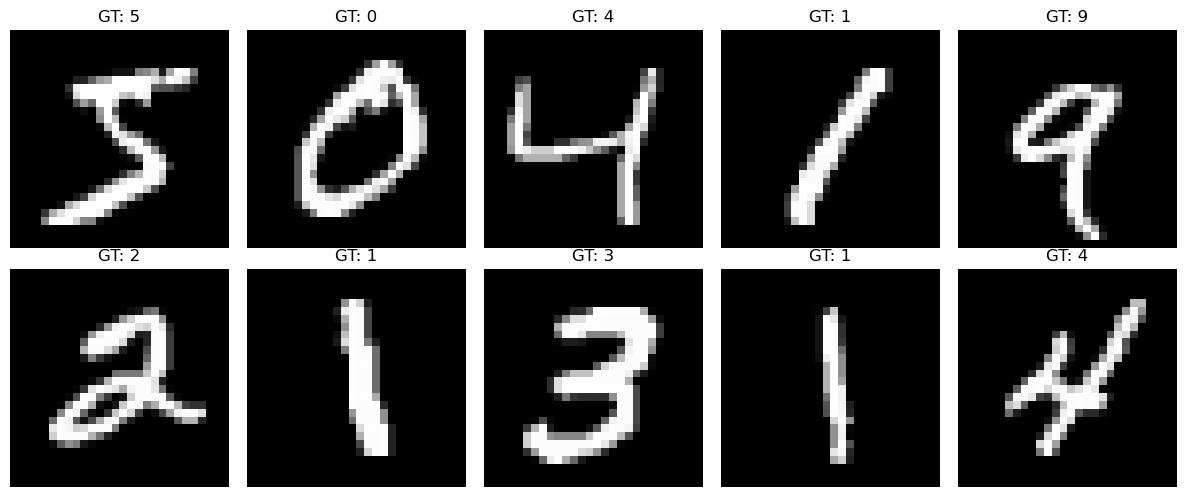

In [7]:
plot_images_grid(x_train[:10].reshape(-1,28,28,1), labels=y_train[:10], class_names=[str(i) for i in range(10)], rows=2, cols=5)

### Preprocessing the Dataset for Model Training

This cell prepares the MNIST data for input into the CNN by normalizing and encoding it into suitable formats.  

- **Reshaping images**: The training and test image arrays are reshaped from 3D `(samples, 28, 28)` to 4D `(samples, 28, 28, 1)` by adding a channel dimension. This matches the expected input shape for convolutional layers, where the last dimension represents the number of channels (1 for grayscale).  
- **Normalization**: Pixel values are converted from integers [0-255] to floats [0.0-1.0] by dividing by 255. This helps the model train more effectively by scaling inputs to a consistent range.  
- **One-hot encoding labels**: The labels `y_train` and `y_test`, which are integers representing digits 0 to 9, are converted into one-hot encoded vectors with 10 elements each. This format is required for multi-class classification loss and output layers.  
- Finally, the shapes of the preprocessed training and test image arrays are printed to confirm the transformation and proper data formatting before model training.

In [8]:
x_train_m = x_train.reshape(-1,28,28,1).astype('float32') / 255.0
x_test_m = x_test.reshape(-1,28,28,1).astype('float32') / 255.0

y_train_m = keras.utils.to_categorical(y_train, 10)
y_test_m = keras.utils.to_categorical(y_test, 10)

print('After preprocess:', x_train_m.shape, x_test_m.shape)

After preprocess: (60000, 28, 28, 1) (10000, 28, 28, 1)


### Building the CNN Model

This cell defines and compiles a Convolutional Neural Network (CNN) model using TensorFlow Keras’ Sequential API for MNIST image classification.  

- The model starts with a **Conv2D layer** with 32 filters and a 3x3 kernel size, using ReLU activation. It accepts input images of shape 28x28x1 (grayscale). This layer extracts low-level features like edges.  
- A **MaxPooling2D layer** with 2x2 pool size follows to reduce spatial dimensions and control overfitting by downsampling the feature maps.  
- Next, another **Conv2D layer** with 64 filters and 3x3 kernel size extracts more complex features, followed by another 2x2 max pooling layer for further spatial reduction.  
- The output is then **flattened** into a 1D vector to prepare for fully connected layers.  
- A **Dense layer** with 128 neurons and ReLU activation learns high-level feature representations from the flattened outputs.  
- A **Dropout layer** with a rate of 0.25 is added to reduce overfitting by randomly disabling 25% of neurons during training.  
- Finally, a **Dense output layer** with 10 neurons (one per class) using softmax activation outputs class probabilities for the 10 digit classes.  

The model is compiled with:  
- **Adam optimizer**, a widely used adaptive learning rate optimizer for efficient training.  
- **Categorical crossentropy loss**, suitable for multi-class classification with one-hot encoded labels.  
- **Accuracy metric** for performance monitoring during training and evaluation.  

The `summary()` method prints a detailed overview of the model architecture, including layer types, output shapes, and number of trainable parameters.

In [9]:
mnist_model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

mnist_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mnist_model.summary()

/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Training the CNN Model

This cell trains the previously defined CNN model on the preprocessed MNIST training data.  

- The `fit` method is called on `mnist_model` with the training images and their one-hot encoded labels.  
- Validation data `(x_test_m, y_test_m)` is provided to monitor the model’s performance on unseen test data after each epoch.  
- The model is trained for 5 epochs, where one epoch means the model has seen the entire training dataset once.  
- A batch size of 64 is used, meaning the model processes 64 samples at a time before updating weights, balancing speed and memory efficiency.  
- The `verbose=2` setting prints concise epoch-wise training logs including loss and accuracy metrics for both training and validation sets.  

The elapsed training time is calculated using the `time` module to measure how long the process takes in seconds, providing an idea of computational cost.

In [10]:
start = time.time()
history_mnist = mnist_model.fit(
    x_train_m, y_train_m,
    validation_data=(x_test_m, y_test_m),
    epochs=5,
    batch_size=64,
    verbose=2
)
print('Training elapsed (s):', time.time() - start)

Epoch 1/5
938/938 - 11s - 12ms/step - accuracy: 0.9448 - loss: 0.1847 - val_accuracy: 0.9815 - val_loss: 0.0542
Epoch 2/5
938/938 - 11s - 11ms/step - accuracy: 0.9806 - loss: 0.0630 - val_accuracy: 0.9882 - val_loss: 0.0356
Epoch 3/5
938/938 - 11s - 12ms/step - accuracy: 0.9860 - loss: 0.0456 - val_accuracy: 0.9887 - val_loss: 0.0325
Epoch 4/5
938/938 - 11s - 12ms/step - accuracy: 0.9893 - loss: 0.0351 - val_accuracy: 0.9914 - val_loss: 0.0265
Epoch 5/5
938/938 - 11s - 12ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.9926 - val_loss: 0.0216
Training elapsed (s): 55.625048875808716


### Evaluating the Model on Test Data

This cell evaluates the trained CNN model on the MNIST test set to measure its final performance.  

- The `evaluate` method computes the loss and accuracy of the model using the preprocessed test images and one-hot encoded labels.  
- The results are stored in `mnist_eval`, where `mnist_eval[0]` is the test loss and `mnist_eval[1]` is the test accuracy as a decimal.  
- The test loss and accuracy are then printed in a formatted way, converting accuracy to a percentage with two decimal places for readability.  

After evaluation, the training and validation accuracy and loss curves for the entire training process are visualized using the previously defined `plot_history` function, with the title prefix set to 'MNIST' for context.  

This step provides a clear summary of the model’s classification ability on unseen data and visually confirms the training dynamics.

MNIST test loss: 0.0216, test acc: 99.26%


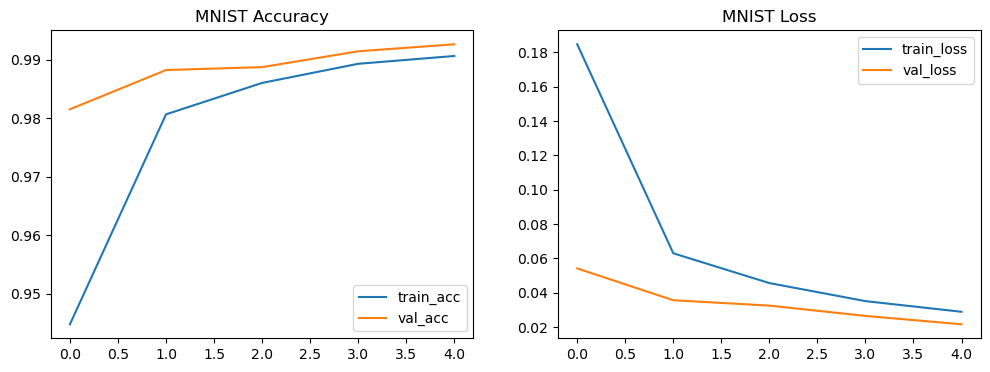

In [11]:
mnist_eval = mnist_model.evaluate(x_test_m, y_test_m, verbose=0)
print(f"MNIST test loss: {mnist_eval[0]:.4f}, test acc: {mnist_eval[1]*100:.2f}%")
plot_history(history_mnist, title_prefix='MNIST')

### Generating Predictions and Plotting Confusion Matrix

This cell predicts the classes for the MNIST test images using the trained model and evaluates detailed classification performance.  

- The `predict` method outputs class probabilities for each test image in `y_pred_m`.  
- `np.argmax` is used to convert these probabilities into predicted class labels by selecting the class with the highest probability for each sample.  
- A confusion matrix `cm_m` is computed by comparing the true labels `y_test` (original integer labels) with the predicted labels.  
- Finally, the confusion matrix is visualized using the `plot_confusion` function, labeling the axes with the digit classes 0 through 9.  

This plot helps identify how well the model distinguishes between individual digits and highlights where misclassifications occur most frequently.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


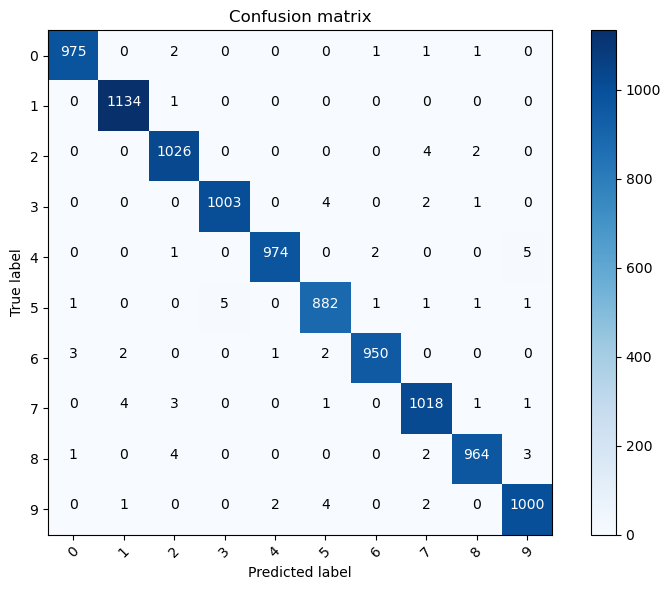

In [12]:
y_pred_m = mnist_model.predict(x_test_m)
y_pred_labels_m = np.argmax(y_pred_m, axis=1)
cm_m = confusion_matrix(y_test, y_pred_labels_m)
plot_confusion(cm_m, [str(i) for i in range(10)])

### Loading the CIFAR-10 Dataset

This cell loads the CIFAR-10 dataset, a collection of 60,000 color images across 10 different classes, from TensorFlow’s dataset module.  

- The dataset is split into training `(x_train_c, y_train_c)` and test `(x_test_c, y_test_c)` sets.  
- `x_train_c` contains color images of shape 32x32 pixels with 3 color channels (RGB).  
- `y_train_c` contains the corresponding class labels as integers for each image.  
- The class names list defines human-readable labels for the 10 categories like 'airplane', 'automobile', 'bird', etc.  
- Shapes of the training images and labels arrays are printed to confirm dataset dimensions and structure.  

CIFAR-10 is widely used for benchmarking image classification on small natural images with more complexity than MNIST.

In [13]:
from tensorflow.keras.datasets import cifar10
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('CIFAR shapes:', x_train_c.shape, y_train_c.shape)

CIFAR shapes: (50000, 32, 32, 3) (50000, 1)


### Displaying Sample CIFAR-10 Images

This cell visualizes the first 10 images from the CIFAR-10 training set using the `plot_images_grid` function.  

- The RGB images are directly passed without reshaping since they already include the channel dimension (32x32x3).  
- Labels are flattened from their original shape to match the expected input format for the plotting function.  
- The class names list is used to convert numeric labels into descriptive category names (e.g., 'airplane', 'dog').  
- The grid layout is set to 2 rows and 5 columns with an increased figure size for better visibility of the colorful images.  

This visualization provides an intuitive look at the dataset’s diversity and complexity compared to MNIST.

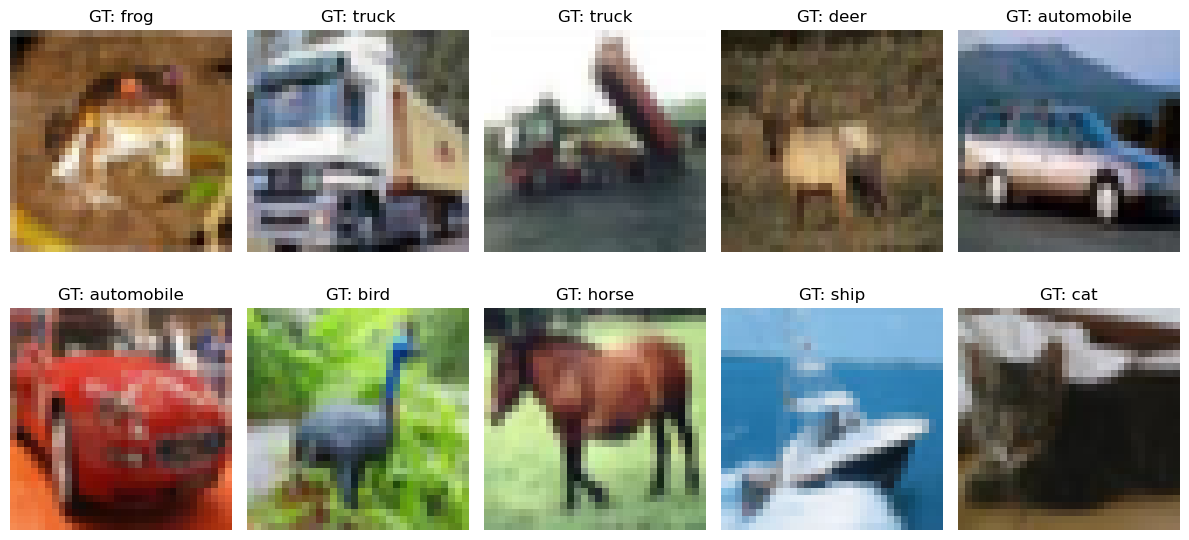

In [14]:
plot_images_grid(x_train_c[:10], labels=y_train_c.flatten()[:10], class_names=class_names, rows=2, cols=5, figsize=(12,6))

### Preprocessing the CIFAR-10 Dataset

This cell prepares the CIFAR-10 data for training by normalizing pixel values and one-hot encoding the labels.  

- The image data `x_train_c` and `x_test_c` are converted from integers to floating-point numbers and normalized to the [0, 1] range by dividing by 255.0. This scaling improves model training stability and convergence.  
- The labels `y_train_c` and `y_test_c` are converted to one-hot encoded vectors with 10 classes using Keras utilities. This format is required for categorical classification with softmax output layers.  

After this preprocessing, the data is ready to be fed into a CNN for training on the CIFAR-10 task.

In [15]:
x_train_c = x_train_c.astype('float32') / 255.0
x_test_c = x_test_c.astype('float32') / 255.0

y_train_c_cat = keras.utils.to_categorical(y_train_c, 10)
y_test_c_cat = keras.utils.to_categorical(y_test_c, 10)

### Creating TensorFlow Datasets for Efficient Training

This cell creates TensorFlow `Dataset` objects from the preprocessed CIFAR-10 training and test data to enable efficient input pipeline management during model training.  

- `from_tensor_slices` converts the image and label NumPy arrays into a dataset where each element consists of one image-label pair, slicing along the first dimension.  
- For the training dataset (`train_ds`):  
  - The data is shuffled with a buffer size of 5000 to randomize the order, which helps improve generalization by reducing bias from input order.  
  - The dataset is batched with a batch size of 64, grouping samples for efficient training updates.  
  - `cache()` stores the dataset in memory after the first epoch to speed up subsequent epochs.  
  - `prefetch(AUTOTUNE)` overlaps data preprocessing and model execution to optimize performance dynamically using TensorFlow’s autotuning.  

- For the validation dataset (`val_ds`), shuffling is omitted to preserve the test set order, but batching, caching, and prefetching are still applied for efficiency.  

- Printing `train_ds` provides a summary of the dataset object, showing its structure and transformations.

This approach improves training performance and resource utilization, especially handling large datasets like CIFAR-10 efficiently.

In [16]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train_c, y_train_c_cat))
train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test_c, y_test_c_cat))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>


### Building an Advanced CNN for CIFAR-10

This cell defines a more complex convolutional neural network optimized for the CIFAR-10 dataset using the Keras functional API.  

- The model input shape is set to 32x32 pixels with 3 color channels (RGB).  
- The architecture consists of several convolutional blocks:  
  - Two Conv2D layers with 32 filters each and kernel size 3x3, using ReLU activation and same padding to preserve spatial dimensions.  
  - A MaxPooling2D layer (2x2) to downsample the feature maps, followed by a 20% Dropout to reduce overfitting.  
  - Two Conv2D layers with 64 filters, again followed by max pooling and a stronger 30% Dropout.  
  - One Conv2D layer with 128 filters, max pooling, then flattening to convert spatial features to a vector.  
- A Dense layer with 256 neurons and ReLU activation learns high-level representations from the extracted features.  
- A Dropout with 40% rate further regularizes the model.  
- The final Dense layer uses softmax activation to output class probabilities for 10 CIFAR classes.  

The model is compiled with:  
- **Adam optimizer** using a learning rate of 0.001, a commonly effective choice known for adaptive learning rates and good convergence in image tasks.  
- **Categorical crossentropy loss** for multi-class classification with one-hot labels.  
- **Accuracy metric** to track performance during training and evaluation.  

The model summary displays layer types, output shapes, and parameter counts, providing an overview of the network complexity and size.  

Adam at this learning rate is a strong default for CIFAR-10 models and balances training speed with convergence quality.

In [17]:
def build_advanced_cifar_model(input_shape=(32,32,3), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inp, out, name='adv_cifar_net')
    return model

cifar_model = build_advanced_cifar_model()
cifar_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
cifar_model.summary()

Model: "adv_cifar_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,538 (2.54 MB)

 Trainable params: 666,538 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

### Setting Up Callbacks and Mixed Precision Policy

This cell configures important training callbacks and optionally enables mixed precision if a GPU is detected.  

- **Callbacks defined:**  
  - `EarlyStopping`: Monitors validation loss and stops training early if it doesn't improve for 5 consecutive epochs, restoring the model weights from the best epoch. This prevents overfitting and saves time.  
  - `ReduceLROnPlateau`: Reduces the learning rate by half if the validation loss plateaus for 3 epochs, helping the model escape local minima and improve convergence.  
  - `ModelCheckpoint`: Saves the best model to a file (`best_cifar_model.h5`) based on validation loss, allowing recovery of the best-performing model after training.  

- **Mixed precision policy:**  
  - The code attempts to import TensorFlow mixed precision utilities and checks if a GPU is available.  
  - If a GPU or accelerator is detected, mixed precision is enabled using the `'mixed_float16'` policy, which uses float16 where safe for faster computation and float32 where higher precision is needed. This can significantly speed up training on compatible hardware.  
  - On CPU-only machines (like MacBook Air here), mixed precision is skipped since it usually doesn't provide speed benefits and may cause issues.  
  - The process is wrapped in a try-except block to handle any configuration errors gracefully and provide informative print messages about the status.

This setup enhances training efficiency, stability, and recovery for the CIFAR-10 model, adapting automatically based on hardware availability.

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    keras.callbacks.ModelCheckpoint('best_cifar_model.h5', save_best_only=True, monitor='val_loss')
]

# Since I'm On CPU, mixed precision usually doesn't speed up. If you have GPU/metal, you can enable it.
try:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    # detect if a GPU/accelerator is present
    if len(tf.config.list_physical_devices('GPU')) > 0:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Enabled mixed precision policy', policy)
    else:
        print('No GPU detected: skipping mixed precision (CPU-only)')
except Exception as e:
    print('Mixed precision not configured:', e)

Mixed precision not configured: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/_tf_keras/keras/mixed_precision/__init__.py)


### Training the CIFAR-10 Model with Callbacks

This cell initiates the training process for the advanced CIFAR-10 CNN model using the prepared dataset pipeline and configured callbacks.  

- The model is trained on `train_ds`, the TensorFlow dataset pipeline for CIFAR-10 training data, which includes batching, shuffling, caching, and prefetching.  
- Validation is performed on `val_ds`, the test set pipeline.  
- Training runs for up to 12 epochs, but the actual number may be less due to early stopping if the validation loss does not improve for 5 consecutive epochs.  
- The three callbacks control training by stopping early, reducing learning rate on plateau, and saving the best model based on validation loss.  
- `verbose=2` provides concise epoch-level logging of training and validation metrics.  

The total training time is measured and printed, offering insights into the time cost of training on the available hardware.  

This approach balances training efficiency, performance monitoring, and resource management on CPU or GPU.

In [19]:
start = time.time()
history_cifar = cifar_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=callbacks,
    verbose=2
)
print('CIFAR training elapsed (s):', time.time() - start)

Epoch 1/12


782/782 - 65s - 83ms/step - accuracy: 0.3987 - loss: 1.6286 - val_accuracy: 0.5399 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 2/12


782/782 - 66s - 84ms/step - accuracy: 0.5834 - loss: 1.1635 - val_accuracy: 0.6316 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 3/12


782/782 - 67s - 86ms/step - accuracy: 0.6543 - loss: 0.9825 - val_accuracy: 0.6933 - val_loss: 0.8658 - learning_rate: 0.0010
Epoch 4/12


782/782 - 68s - 87ms/step - accuracy: 0.6968 - loss: 0.8644 - val_accuracy: 0.7170 - val_loss: 0.8070 - learning_rate: 0.0010
Epoch 5/12


782/782 - 70s - 89ms/step - accuracy: 0.7224 - loss: 0.7941 - val_accuracy: 0.7459 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 6/12


782/782 - 76s - 97ms/step - accuracy: 0.7411 - loss: 0.7393 - val_accuracy: 0.7583 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 7/12


782/782 - 70s - 90ms/step - accuracy: 0.7604 - loss: 0.6833 - val_accuracy: 0.7638 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 8/12


782/782 - 70s - 90ms/step - accuracy: 0.7723 - loss: 0.6479 - val_accuracy: 0.7745 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 9/12


782/782 - 71s - 90ms/step - accuracy: 0.7822 - loss: 0.6191 - val_accuracy: 0.7886 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 10/12
782/782 - 72s - 92ms/step - accuracy: 0.7952 - loss: 0.5833 - val_accuracy: 0.7835 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 11/12
782/782 - 71s - 91ms/step - accuracy: 0.8008 - loss: 0.5648 - val_accuracy: 0.7889 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 12/12


782/782 - 71s - 91ms/step - accuracy: 0.8074 - loss: 0.5485 - val_accuracy: 0.7973 - val_loss: 0.6198 - learning_rate: 0.0010
CIFAR training elapsed (s): 837.6602568626404


### Evaluating the CIFAR-10 Model on Test Data

This cell evaluates the trained CIFAR-10 model using the validation dataset to determine its final classification performance.  

- The `evaluate` method calculates the loss and accuracy over the entire test data pipeline (`val_ds`).  
- The results include test loss (a measure of prediction error) and test accuracy (percentage of correct predictions).  
- These metrics are printed in a formatted manner with loss to four decimal places and accuracy as a percentage with two decimals.  

After evaluation, the training history is visualized using the `plot_history` function with the prefix 'CIFAR-10' to display accuracy and loss curves over epochs for both training and validation data.  

This provides a comprehensive view of how well the model generalizes to unseen data and confirms its learning progress during training.

CIFAR test loss: 0.6198, test acc: 79.73%


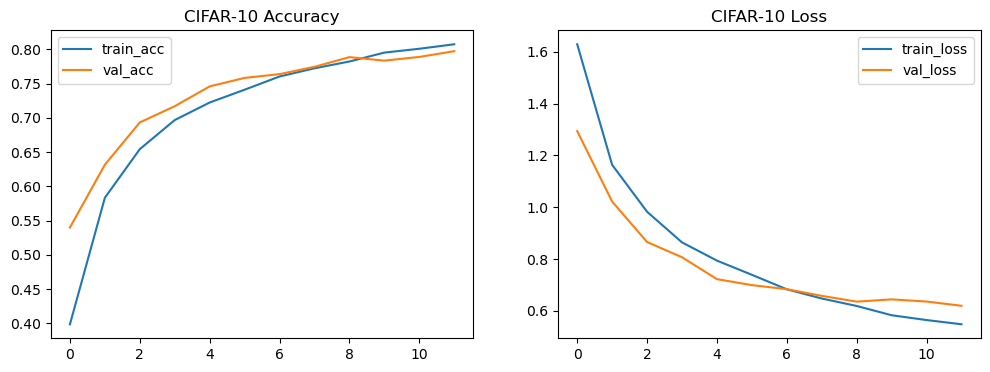

In [20]:
cifar_eval = cifar_model.evaluate(val_ds, verbose=0)
print(f"CIFAR test loss: {cifar_eval[0]:.4f}, test acc: {cifar_eval[1]*100:.2f}%")
plot_history(history_cifar, title_prefix='CIFAR-10')

### Predicting and Analyzing CIFAR-10 Test Results

This cell performs detailed classification analysis on the CIFAR-10 test dataset.  

- The model generates predictions for the test images using the `predict` method with the predefined batch size for efficient processing.  
- Predicted probabilities are converted to class labels by selecting the highest probability class for each sample.  
- True labels are flattened to a 1D array for comparison with predicted labels.  
- A confusion matrix is computed to visualize the distribution of correct and incorrect predictions across all classes. This matrix is then displayed using the `plot_confusion` function with appropriate class names.  
- The `classification_report` from scikit-learn is printed, providing detailed metrics per class including precision, recall, F1-score, and support (number of samples per class).  

This comprehensive evaluation highlights the model’s strengths and weaknesses on each category, informing areas for potential improvement.

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


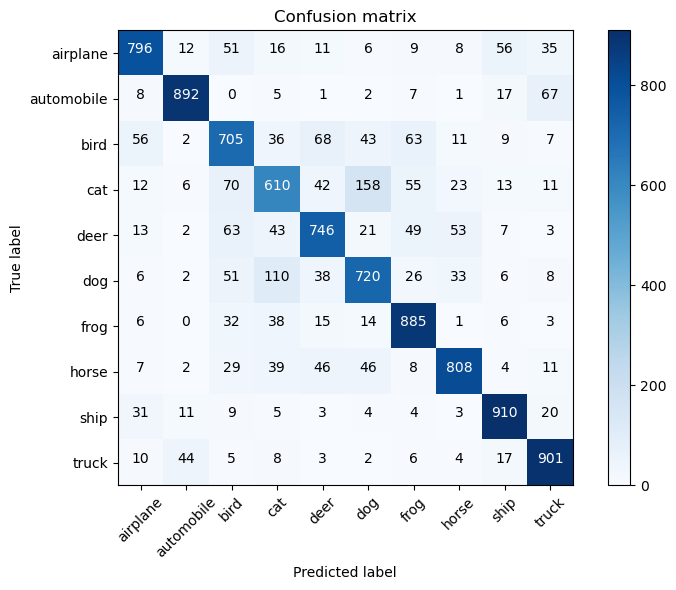

              precision    recall  f1-score   support

    airplane       0.84      0.80      0.82      1000
  automobile       0.92      0.89      0.90      1000
        bird       0.69      0.70      0.70      1000
         cat       0.67      0.61      0.64      1000
        deer       0.77      0.75      0.76      1000
         dog       0.71      0.72      0.71      1000
        frog       0.80      0.89      0.84      1000
       horse       0.86      0.81      0.83      1000
        ship       0.87      0.91      0.89      1000
       truck       0.85      0.90      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [21]:
y_pred_c = cifar_model.predict(x_test_c, batch_size=BATCH_SIZE)
y_pred_labels_c = np.argmax(y_pred_c, axis=1)
y_true_c = y_test_c.flatten()
cm_c = confusion_matrix(y_true_c, y_pred_labels_c)
plot_confusion(cm_c, class_names)
print(classification_report(y_true_c, y_pred_labels_c, target_names=class_names))

### Visualizing Random CIFAR-10 Test Predictions

This cell randomly selects 10 images from the CIFAR-10 test set along with their true and predicted labels to visualize model performance on individual samples.  

- Random indices are generated without replacement to pick diverse test images.  
- The selected images, true labels, and predicted labels are extracted using these indices.  
- The `plot_images_grid` function displays these images in a 2-row, 5-column grid, showing the ground truth and predicted class names as titles.  
- This visualization helps to visually assess where the model is making correct or incorrect predictions, providing intuitive insights beyond aggregate metrics.

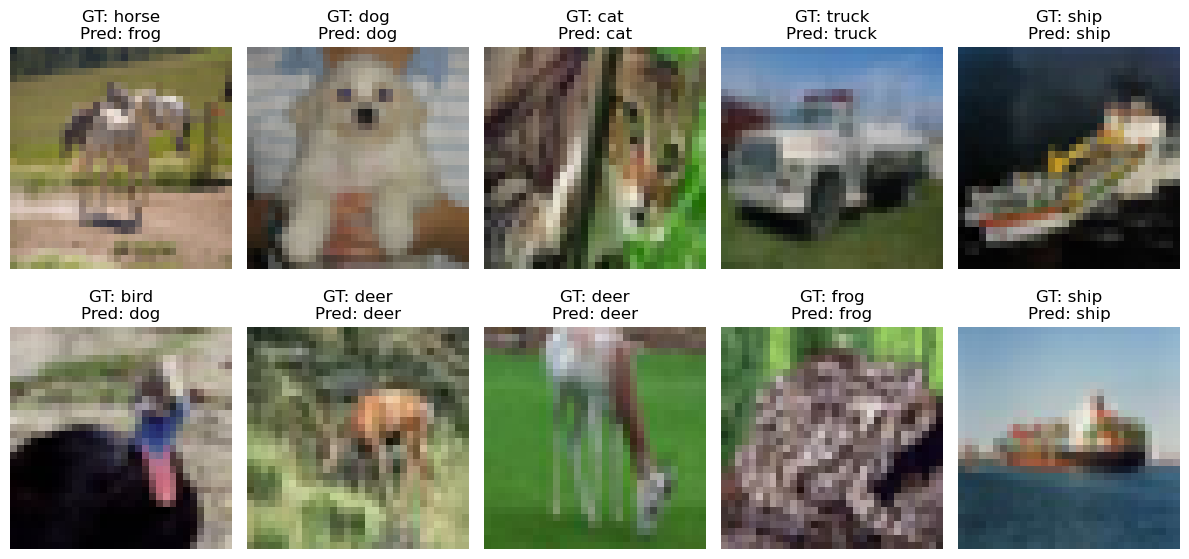

In [22]:
idxs = np.random.choice(len(x_test_c), size=10, replace=False)
images = x_test_c[idxs]
true_labels = y_true_c[idxs]
pred_labels = y_pred_labels_c[idxs]
plot_images_grid(images, labels=true_labels, preds=pred_labels, class_names=class_names, rows=2, cols=5, figsize=(12,6))

### Preparing CIFAR-10 Dataset for Transfer Learning with ResNet50

This cell prepares the CIFAR-10 dataset for transfer learning using the pretrained ResNet50 model by resizing images and creating TensorFlow datasets.  

- The ResNet50 model expects larger input images (commonly 224x224), but here the size is set to 160x160 to avoid kernel crashes and reduce training time on a CPU.  
- The class labels are converted from one-hot encoded vectors back to integer labels using `np.argmax`, as ResNet50 transfer learning typically expects integer labels with sparse categorical loss.  
- A preprocessing function `preprocess` resizes each image to the target size `(160, 160)` using TensorFlow’s efficient image resizing.  
- TensorFlow datasets for training and validation are created from image-label pairs, applying the resize function on-the-fly with parallel execution for speed.  
- The training dataset is shuffled, batched (batch size 32), cached, and prefetched for efficient input pipeline performance.  
- The validation dataset is batched, cached, and prefetched similarly but without shuffling, preserving evaluation order.  

This dataset pipeline enables seamless, memory-efficient loading and resizing of CIFAR-10 images, ready for fine-tuning a ResNet50 model on CPU.

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

IMG_SIZE = 160   # The kernel was crashing for larger size, hence taken smaller size for faster training on CPU
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

y_train_int = np.argmax(y_train_c, axis=1)
y_test_int = np.argmax(y_test_c, axis=1)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("Building datasets with on-the-fly resizing...")
train_ds_tl = tf.data.Dataset.from_tensor_slices((x_train_c, y_train_int))
train_ds_tl = train_ds_tl.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds_tl = train_ds_tl.shuffle(5000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

val_ds_tl = tf.data.Dataset.from_tensor_slices((x_test_c, y_test_int))
val_ds_tl = val_ds_tl.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds_tl = val_ds_tl.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

print("Datasets ready for transfer learning")

Building datasets with on-the-fly resizing...
Datasets ready for transfer learning


### Building a Transfer Learning Model Using ResNet50

This cell constructs a transfer learning model leveraging the pretrained ResNet50 architecture as a fixed feature extractor for CIFAR-10 classification.  

- The pretrained **ResNet50** model is loaded without its top classification layer (`include_top=False`), with input shape adapted to the resized images (160x160 RGB).  
- The base convolutional layers of ResNet50 are **frozen** (`trainable=False`) so their pretrained ImageNet features remain unchanged during initial training. This allows learning new classifications efficiently without retraining the large base model.  
- A new model is built using Keras Sequential API, adding:  
  - The frozen ResNet50 base for feature extraction.  
  - A **GlobalAveragePooling2D** layer that reduces each feature map to a single value by averaging, reducing tensor size while retaining spatial information.  
  - A Dense layer with 128 neurons and ReLU activation to learn high-level representations specific to CIFAR-10.  
  - A Dropout layer with 30% rate to regularize and prevent overfitting.  
  - A final Dense layer with 10 neurons and softmax activation for outputting class probabilities.  

The model is compiled with:  
- **Adam optimizer** for adaptive learning rate optimization.  
- **Sparse categorical crossentropy loss**, compatible with integer labels (not one-hot encoded).  
- **Accuracy** as the evaluation metric.  

The `summary()` prints layer details, parameter counts, and confirms that the pretrained base is frozen, setting the stage for efficient feature-based training on CIFAR-10.

In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False   # Freeze base for feature extraction

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Training the Transfer Learning ResNet50 Model

This cell trains the ResNet50-based transfer learning model on the resized CIFAR-10 dataset using the prepared TensorFlow dataset pipelines.  

- The model is trained on `train_ds_tl`, which includes on-the-fly resized CIFAR-10 images and integer labels.  
- Validation is performed on `val_ds_tl` to monitor performance on unseen data after each epoch.  
- Training runs for 3 epochs, a small number suitable for CPU training to balance time and performance. For GPU setups, longer training with more epochs is recommended.  
- The `verbose=1` setting provides detailed per-epoch progress, including loss and accuracy metrics for training and validation phases.  

This step fine-tunes the top layers added on ResNet50, adapting pretrained features to the CIFAR-10 classification problem efficiently on limited hardware.

In [25]:
history_resnet = resnet_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=3,      # Keeping epochs small for CPU, Keep larger epochs if you have GPUs
    verbose=1
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1402s 895ms/step - accuracy: 0.9985 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 2.0162e-07
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1510s 966ms/step - accuracy: 1.0000 - loss: 1.5777e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1534s 982ms/step - accuracy: 1.0000 - loss: 5.2474e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


### Fine-Tuning the Pretrained ResNet50 Base Model

This cell enables fine-tuning of the pretrained ResNet50 layers for improved CIFAR-10 performance by unfreezing and training the last few layers.  

- The entire base ResNet50 model is first set to trainable, then layers except for the last ~30 are frozen to limit training to the higher, more specialized convolutional blocks.  
- This selective unfreezing allows the model to adapt pretrained features to CIFAR-10 specifics while preserving learned low-level features in earlier layers, preventing overfitting and reducing training time.  
- The model is recompiled with a much lower learning rate (`1e-5`) suitable for fine-tuning to make small weight adjustments without large disruptive updates.  
- The model is trained again for 2 additional epochs on the training dataset with validation monitoring, providing a short fine-tuning phase tailored for smaller hardware setups or quick iteration.  

This fine-tuning step can improve accuracy by adapting high-level features to target data while maintaining stable pretrained weights elsewhere.

In [26]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze most layers, unfreeze last ~30
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_resnet_ft = resnet_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=2,   # Only a couple epochs since i'm on only GPU systems.
    verbose=1
)

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2045s 1s/step - accuracy: 1.0000 - loss: 1.5605e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2692s 2s/step - accuracy: 1.0000 - loss: 1.0256e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


### Visualizing Model Interpretability Using Grad-CAM (Max Activation)

This cell implements Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of a CIFAR-10 sample image activate the model’s deepest convolutional layer most strongly.  

- A sample test image is resized to the input size used by the ResNet50 model and expanded to a 4D tensor to match model input shape.  
- The `gradcam_max_activation` function computes the heatmap based on the maximum activation channel within the specified last convolutional layer (`conv5_block3_out`):  
  - It tracks the output feature maps and their gradients using TensorFlow’s GradientTape.  
  - Instead of gradients related to a predicted class, it focuses on the channel with the highest activation at the last conv layer.  
  - The gradients are spatially averaged (pooled), and a weighted combination of feature maps produces the heatmap, normalized between 0 and 1.  
- The heatmap shows important spatial regions in the feature maps associated with the strongest activation, highlighting where the model "looks" the most.  
- The heatmap is displayed separately using a color map (`matshow`).  
- The `overlay_heatmap` function resizes the heatmap to image dimensions, applies a Jet colormap, and overlays it on the original image with adjustable transparency (`alpha=0.4`).  
- The combined visualization shows the original image with a colored heatmap superimposed, visually indicating the regions contributing most to the model’s internal activations for that input.  

This technique helps interpret the model’s focus and decision-making for a given input, providing insights into model behavior at a spatial level.

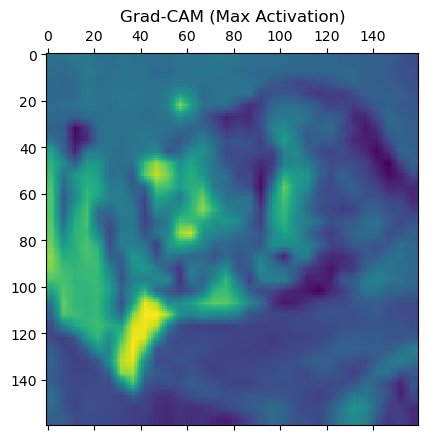

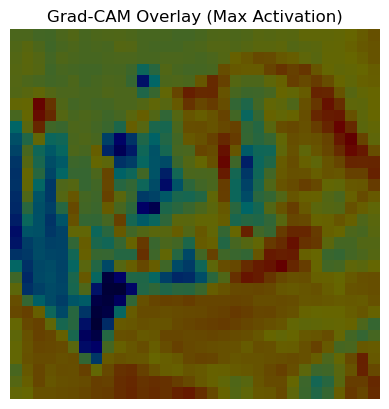

In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Pick a sample image
sample_img = x_test_c[0]
sample_array = tf.image.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_array = tf.expand_dims(sample_array, axis=0)  # (1,H,W,3)

# Grad-CAM: max activation channel
def gradcam_max_activation(base_model, img_array, last_conv_layer_name):
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer(img_array)
        tape.watch(conv_outputs)
        # Use max channel activation instead of predicted class
        max_channel = tf.reduce_max(conv_outputs, axis=-1)
    
    grads = tape.gradient(max_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate heatmap
heatmap = gradcam_max_activation(base_model, sample_array, 'conv5_block3_out')

# Display heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM (Max Activation)")
plt.show()

# Overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    return np.uint8(superimposed_img)

superimposed_img = overlay_heatmap(sample_img, heatmap)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM Overlay (Max Activation)")
plt.show()

### Test Time Augmentation (TTA) for Robust Predictions

This cell defines a function `tta_predict` that performs Test Time Augmentation (TTA) to improve prediction reliability by averaging model outputs over multiple augmented versions of a single input image.  

- The function takes a single image and resizes it to the model’s expected input size.  
- For each of the specified `tta_steps`, it applies random augmentations including:  
  - Random horizontal flip  
  - Random vertical flip  
  - Random slight rotation within ±0.1 radians (if TensorFlow Addons `tfa` is available; skips otherwise)  
- The augmented image is passed through the model in inference mode (`training=False`) to get prediction probabilities.  
- Predictions from all augmented versions are collected and averaged to produce a final, more robust prediction.  

This method helps reduce sensitivity to small variations or noise in the input, improving confidence and accuracy during evaluation or deployment.  

An example is shown using the first CIFAR-10 test image with 3 augmentations, printing the averaged prediction probabilities from the transfer learning model.

In [48]:
# Test Time Augmentation
def tta_predict(model, img, img_size=IMG_SIZE, tta_steps=5):
    """
    img: single image (H,W,3)
    tta_steps: number of augmentations
    """
    preds = []
    img_array = tf.image.resize(img, (img_size, img_size))
    img_array = tf.expand_dims(img_array, axis=0)

    for i in range(tta_steps):
        # Random flip & slight rotation
        aug = tf.image.random_flip_left_right(img_array)
        aug = tf.image.random_flip_up_down(aug)
        angle = tf.random.uniform([], minval=-0.1, maxval=0.1)
        aug = tfa.image.rotate(aug, angle) if 'tfa' in globals() else aug
        pred = model(aug, training=False)
        preds.append(pred.numpy())
    
    return np.mean(preds, axis=0)

# Example usage
sample_img = x_test_c[0]
tta_pred = tta_predict(resnet_model, sample_img, tta_steps=3)
print("TTA prediction probabilities:", tta_pred)

TTA prediction probabilities: [[1.0000000e+00 2.7828461e-14 6.7460706e-14 3.1220152e-16 6.0923488e-15
  9.6891950e-14 4.6209438e-15 3.4079272e-15 8.9851358e-15 2.2533412e-15]]


### Implementing a Simple Model Ensemble with TTA

This cell defines a `simple_ensemble` function that combines predictions from multiple models to improve robustness and accuracy.  

- For each model in the provided list, it calls the previously defined `tta_predict` function to get augmented predictions for the input image.  
- It collects all predictions from the different models and computes the average, producing an ensemble prediction.  
- This averaging helps reduce individual model biases and variance, often leading to better overall performance.  

An example demonstrates the ensemble with just one model (the transfer learning ResNet50 model) and 3 TTA steps, printing the resulting averaged prediction probabilities.  

This structure can be easily extended to combine multiple trained models for better prediction confidence.

In [49]:
def simple_ensemble(models, img, tta_steps=3):
    preds = []
    for m in models:
        p = tta_predict(m, img, tta_steps=tta_steps)
        preds.append(p)
    return np.mean(preds, axis=0)

# Example: ensemble of just one model for demonstration
ensemble_pred = simple_ensemble([resnet_model], sample_img, tta_steps=3)
print("Ensemble prediction:", ensemble_pred)

Ensemble prediction: [[1.0000000e+00 2.1691958e-14 5.5267121e-14 2.9083776e-16 6.1121508e-15
  8.5336367e-14 4.0397000e-15 3.2917100e-15 8.5421358e-15 2.0380081e-15]]


### Saving the Entire Model to Disk

This cell saves the complete ResNet50-based CIFAR-10 model including its architecture, trained weights, and optimizer state into a single HDF5 file named `resnet_cifar10_cpu_model.h5`.  

- Using the `save` method with `.h5` extension stores all necessary components for later restoration and inference or further training.  
- This allows easy sharing, deployment, or resuming of model training without needing to reconstruct the model from code.

In [50]:
# Save entire model (architecture + weights + optimizer)
resnet_model.save("resnet_cifar10_cpu_model.h5")
print("Model saved as resnet_cifar10_cpu_model.h5")

Model saved as resnet_cifar10_cpu_model.h5


### Loading and Testing the Saved Model

This cell demonstrates how to load the previously saved ResNet50 CIFAR-10 model from the HDF5 file.  

- The `load_model` function restores the entire model including architecture, weights, and optimizer state for immediate use.  
- A confirmation message indicates successful loading.  
- The same sample CIFAR-10 test image is resized and expanded to match input shape requirements, then passed to the loaded model to generate predictions.  
- The predicted class is extracted using `np.argmax` and printed, confirming the loaded model’s functionality.  

This workflow verifies that the saved model can be restored for predictions or further training without issues.

In [51]:
from tensorflow.keras.models import load_model

loaded_model = load_model("resnet_cifar10_cpu_model.h5")
print("Model loaded successfully!")

# Test on a sample image
sample_array = tf.expand_dims(tf.image.resize(x_test_c[0], (IMG_SIZE, IMG_SIZE)), axis=0)
pred = loaded_model(sample_array)
print("Loaded model prediction:", np.argmax(pred[0]))

Model loaded successfully!
Loaded model prediction: 0
